In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu

In [2]:
#spot price
s0 = 100.0
#strike price
k = 100.0
#Time to expiry
T = 1.0
#risk free rate
r = 0.1
#volatility
sigma = 0.2
x0 = np.log(s0)

closed form solution for Binary call option is the expectation of ST>K discounted by risk free rate for a time equal to maturity under risk neutrak measure

In [3]:
d2 = (np.log(s0 / k) + (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
Nd2 = ss.norm.cdf(d2) #cummulative distribution

In [10]:
price = np.exp(-r * T) * Nd2
print("The price of the given binary call option is",price)

The price of the given binary call option is 0.5930501164033175


Lets compute the price by Monte carlo method

In [5]:
np.random.seed(42)
#no.of simulations
n = 20000000 
normal = (r - sigma**2 / 2) * T + ss.norm.rvs(loc=0, scale=sigma, size=n)
st =s0*np.exp(normal)

computing the price and standard error associated with price using Monte carlo simulation

In [6]:
montecarlo_price = np.exp(-r*T)*np.mean(st>k)
print(montecarlo_price)
montecarlo_stderror = np.exp(-r*T)*ss.sem(st>k)
print(montecarlo_stderror)

0.593071342432063
9.615080192805355e-05


Computing the price using PDE method(the finite differencing method

In [8]:
Nspace = 6000 #space steops
k =100
Ntime = 6000 # time steps
xmax = np.log(3 * float(k))
xmin = np.log(float(k) / 3)

x, dx = np.linspace(xmin, xmax, Nspace, retstep=True) #space initialization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)  #time initialization
payoff = np.where(np.exp(x) > k, 1, 0) #binary payoff

V = np.zeros((Nspace, Ntime)) # initial grid
offset = np.zeros(Nspace - 2)
 
V[:, -1] = payoff #termianl conditions
V[-1, :] = 1 #boundary condition
V[0, :] = 0 # boundary condition
sigma2 = sigma * sigma
dxx = dx * dx

#conatructing the matrix that we need
a = (dt / 2) * ((r - 0.5 * sigma2) / dx - sigma2 / dxx)
b = 1 + dt * (sigma2 / dxx + r)
c = -(dt / 2) * ((r - 0.5 * sigma2) / dx + sigma2 / dxx)
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()
DD = splu(D)

#Backward iteration 
for i in range(Ntime - 2, -1, -1):
    offset[0] = a * V[0, i]
    offset[-1] = c * V[-1, i]
    V[1:-1, i] = DD.solve(V[1:-1, i + 1] - offset)

finite_differencing_price = np.interp(x0, x, V[:, 0])
print("The price of the ATM digital call option by PDE is: ",finite_differencing_price)

The price of the ATM digital call option by PDE is:  0.5930462329429457


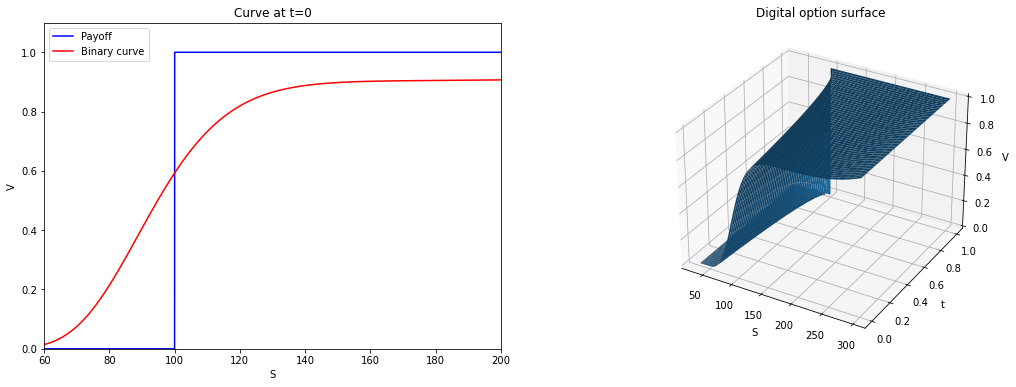

In [9]:
S = np.exp(x)
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")
ax1.plot(S, payoff, color="blue", label="Payoff")
ax1.plot(S, V[:, 0], color="red", label="Binary curve")
ax1.set_xlim(60, 200)
ax1.set_ylim(0, 1.1)
ax1.set_xlabel("S")
ax1.set_ylabel("V")
ax1.legend(loc="upper left")
ax1.set_title("Curve at t=0")

X, Y = np.meshgrid(T_array, S)
ax2.plot_surface(Y, X, V)
ax2.set_title("Digital option surface")
ax2.set_xlabel("S")
ax2.set_ylabel("t")
ax2.set_zlabel("V")
plt.show()